# Script to aquire and pre-process all data for the model

Very useful packages:
- https://samgeo.gishub.org/installation/ to convert TMS to GeoTIFF and  also to segment satellite images in general
- https://gdal.org/en/stable/programs/gdal_translate.html to convert geodata formats 
- https://rasterio.readthedocs.io/en/stable/ to rasterize OSM vector data or to visualize a raster
- https://osmnx.readthedocs.io/en/stable/ to easily download OSM data
- https://geopandas.org/en/stable/ to handle vector data
- https://docs.xarray.dev/en/stable/ for cube handling of raster data

In [1]:
## Import libraries
# system
import os
import sys
import time
import io
import requests
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, as_completed
from dotenv import load_dotenv


# aws bucket access
import boto3

# data manipulation
import json
from PIL import Image
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import rasterio as rio
import xarray as xr
import rioxarray as rxr
from rasterio.transform import from_bounds
from rasterio.features import geometry_mask, rasterize
from pyproj import Transformer, CRS
from shapely.geometry import box
from shapely import Polygon
#from samgeo import tms_to_geotiff

# visualization
from rasterio.plot import show
import leafmap
from ipyleaflet import Map, WMSLayer, basemaps, TileLayer, DrawControl, FullScreenControl, LayersControl, MeasureControl, SplitMapControl, WidgetControl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm

repo_name = 'masterthesis_genai_spatialplan'
if not repo_name in os.getcwd():
    os.chdir(repo_name)

p=os.popen('git rev-parse --show-toplevel')
repo_dir = p.read().strip()
p.close()

# Load .env file
load_dotenv(dotenv_path=f"{repo_dir}/.env")

True

In [ ]:
sys.path.append("/usr/share/lmod/lmod/init")
from env_modules_python import module

# loading cluster modules
gdal_root = "/software/easybuild/el8/amd_zen3/all/GDAL/3.9.0-foss-2023b"
cuda_root = "/software/easybuild/el8/amd_zen3/all/CUDA/12.6.0"

module("load", "CUDA")
module("load", "GDAL")

os.environ["PATH"] = f"{cuda_root}/bin:{os.environ['PATH']}"
os.environ["LD_LIBRARY_PATH"] = f"{cuda_root}/lib:{os.environ.get('LD_LIBRARY_PATH', '')}"
os.environ["CUDA_HOME"] = cuda_root
os.environ["CUDA_PATH"] = cuda_root

# GDAL setup with corrected paths
os.environ["PATH"] = f"{gdal_root}/bin:{os.environ['PATH']}"
os.environ["LD_LIBRARY_PATH"] = f"{gdal_root}/lib64:{gdal_root}/lib:{os.environ.get('LD_LIBRARY_PATH', '')}"
os.environ["GDAL_DATA"] = f"{gdal_root}/share/gdal"
os.environ["GDAL_DRIVER_PATH"] = f"{gdal_root}/lib64/gdalplugins"
print("GDAL is available: ", os.system("gdalinfo --version")) # Test GDAL

# os.environ["PATH"] = f"{gdal_root}/bin:" + os.environ["PATH"]
# os.environ["LD_LIBRARY_PATH"] = f"{gdal_root}/lib:" + os.environ.get("LD_LIBRARY_PATH", "")
# os.environ["GDAL_DATA"] = f"{gdal_root}/share/gdal"
# os.environ["GDAL_DRIVER_PATH"] = f"{gdal_root}/lib/gdalplugins"

GDAL 3.9.0, released 2024/05/07
GDAL is available:  0


### Get the boundaries of Leipzig

In [12]:
# Define bbox for entire Leipzig
xmin, ymin = 12.2714, 51.2705  # Southwest corner
xmax, ymax = 12.5019, 51.4174  # Northeast corner

# Create bbox polygon
bbox = box(xmin, ymin, xmax, ymax)

# Create GeoDataFrame
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")

bbox_gdf.explore()

### Stadt Leipzig Orthophoto (WMS)

The city of Leipzig created orthophotos of the city in spring 2022: https://www.leipzig.de/bauen-und-wohnen/bauen/geodaten-und-karten/luftbilder-und-orthophotos

The photos are available as a WMS layer under: https://geodienste.leipzig.de/l4/Luftbild_2022/service?request=getCapabilities


In [137]:
# leipzig center
center = [51.340632, 12.374732]
zoom = 13
m = leafmap.Map(center=center, zoom=zoom)
m

Map(center=[51.340632, 12.374732], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [ ]:
#to get drawn areas
m.user_roi_bounds()

[12.3735, 51.324, 12.3935, 51.3321]

Using ipyleaflet

In [138]:
# leipzig center
center = [51.340632, 12.374732]
zoom = 13
m = Map(basemap=basemaps.CartoDB.Positron, center=center, zoom=zoom)

#add layer control
m.add_control(LayersControl())
m.add_control(DrawControl())

m

Map(center=[51.340632, 12.374732], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [139]:
wms = WMSLayer(
    url='https://geodienste.leipzig.de/l4/Luftbild_2022/service',
    layers='Luftbild_2022',
    name='Luftbild 2022',
    format='image/png',
    transparent=True,
    attribution='Stadt Leipzig',
)
m.add_layer(wms)

In [140]:
source_url_google = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}'
google_tiles = TileLayer(url=source_url_google, name='Google Satellite')
m.add_layer(google_tiles)

In [ ]:
bounds = [xmin, ymin, xmax, ymax]
tms_to_geotiff(bbox=bounds, output='google_satellite.tif', source=source_url_google, zoom=13)

In [10]:
def fix_bbox_coordinates(lat1, lon1, lat2, lon2):
    # Create transformer from EPSG:4326 to EPSG:3857
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    
    # Transform coordinates
    x1, y1 = transformer.transform(lon1, lat1)
    x2, y2 = transformer.transform(lon2, lat2)
    
    # Ensure min/max values are in correct order
    min_x, max_x = min(x1, x2), max(x1, x2)
    min_y, max_y = min(y1, y2), max(y1, y2)
    
    return f"{min_x},{min_y},{max_x},{max_y}"

def get_wms_image(bounds, output_tif):
    
    if not os.path.exists(output_tif):
        os.makedirs(os.path.dirname(output_tif), exist_ok=True)
    else:
        return
    
    # Parse bounds [xmin, ymin, xmax, ymax]
    ulx, lry, lrx, uly = bounds
    bbox = fix_bbox_coordinates(uly, ulx, lry, lrx)
    
    url = (
        "https://geodienste.leipzig.de/l4/Luftbild_2022/service"
        f"?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap"
        f"&BBOX={bbox}"
        "&CRS=EPSG:3857"
        "&WIDTH=1024&HEIGHT=1024"
        "&LAYERS=Luftbild_2022&STYLES="
        "&FORMAT=image/png"
    )
    #print(url)
    
    # Download image
    response = requests.get(url)
    if not response.ok:
        raise ValueError(f"WMS request failed: {response.status_code}")
        
    # Verify PNG is valid
    img = Image.open(io.BytesIO(response.content))
    png_path = output_tif.replace(".tif", ".png")
    img.save(png_path)
    
    # Create georeferenced TIF
    transform = from_bounds(ulx, lry, lrx, uly, 1024, 1024)
    
    # Specify driver explicitly for PNG
    with rio.open(
        png_path,
        'r',
        driver='PNG'
    ) as src:
        profile = src.profile
        profile.update({
            'crs': CRS.from_epsg(3857),
            'transform': transform
        })
        
        with rio.open(output_tif, 'w', **profile) as dst:
            dst.write(src.read())
    
    os.system(f"rm -rf {png_path}")

In [11]:
# xmin, ymin, xmax, ymax = gdf.total_bounds
length = 0.005
width = 0.005

cols = list(np.arange(xmin, xmax + width, width))
rows = list(np.arange(ymin, ymax +length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([
            (x, y), (x+width, y), (x+width, y+length), (x, y+length)
        ]))
grid = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")
# grid =gpd.overlay(grid, gdf, how='intersection')
grid.explore()

In [ ]:
def wrap_image_download(geometry):
    bounds = geometry.bounds
    xmin, ymin, xmax, ymax = [str(coord).replace(".", "") for coord in bounds]

    try:
        get_wms_image(bounds, f"{repo_dir}/data/leipzig_aerial_grid/lz_aerial_{xmin}_{ymin}_{xmax}_{ymax}.tif")
    except Exception as e:
        print(f"Failed to download image for {bounds}: {e}")

if __name__ == "__main__":
    
    processes =  int(mp.cpu_count()*0.9)
    # multiprocess grid using tqdm
    with mp.Pool(processes) as pool:
        list(tqdm(pool.imap(wrap_image_download, grid.geometry), total=len(grid)))

  2%|▏         | 22/1410 [00:50<42:59,  1.86s/it] 

Failed to download image for (12.281400000000001, 51.37050000000005, 12.286400000000002, 51.37550000000005): WMS request failed: 504Failed to download image for (12.281400000000001, 51.32550000000003, 12.286400000000002, 51.33050000000003): WMS request failed: 504Failed to download image for (12.281400000000001, 51.39050000000006, 12.286400000000002, 51.39550000000006): WMS request failed: 504
Failed to download image for (12.281400000000001, 51.2805, 12.286400000000002, 51.285500000000006): WMS request failed: 504Failed to download image for (12.2764, 51.37550000000005, 12.281400000000001, 51.380500000000055): WMS request failed: 504Failed to download image for (12.281400000000001, 51.360500000000044, 12.286400000000002, 51.36550000000005): WMS request failed: 504Failed to download image for (12.281400000000001, 51.380500000000055, 12.286400000000002, 51.38550000000006): WMS request failed: 504Failed to download image for (12.281400000000001, 51.35550000000004, 12.286400000000002, 51.

  3%|▎         | 36/1410 [01:00<25:29,  1.11s/it]











Failed to download image for (12.286400000000002, 51.29050000000001, 12.291400000000003, 51.29550000000001): WMS request failed: 504Failed to download image for (12.281400000000001, 51.38550000000006, 12.286400000000002, 51.39050000000006): WMS request failed: 504

Failed to download image for (12.286400000000002, 51.29550000000001, 12.291400000000003, 51.300500000000014): WMS request failed: 504


  5%|▌         | 77/1410 [01:01<07:08,  3.11it/s]

Failed to download image for (12.286400000000002, 51.32550000000003, 12.291400000000003, 51.33050000000003): WMS request failed: 504Failed to download image for (12.286400000000002, 51.37050000000005, 12.291400000000003, 51.37550000000005): WMS request failed: 504Failed to download image for (12.286400000000002, 51.35550000000004, 12.291400000000003, 51.360500000000044): WMS request failed: 504Failed to download image for (12.286400000000002, 51.39050000000006, 12.291400000000003, 51.39550000000006): WMS request failed: 504Failed to download image for (12.286400000000002, 51.31050000000002, 12.291400000000003, 51.31550000000002): WMS request failed: 504Failed to download image for (12.281400000000001, 51.41550000000007, 12.286400000000002, 51.420500000000075): WMS request failed: 504Failed to download image for (12.286400000000002, 51.380500000000055, 12.291400000000003, 51.38550000000006): WMS request failed: 504Failed to download image for (12.286400000000002, 51.33050000000003, 12.2

 14%|█▍        | 197/1410 [02:00<26:29,  1.31s/it]

Failed to download image for (12.301400000000005, 51.360500000000044, 12.306400000000005, 51.36550000000005): WMS request failed: 504


 14%|█▍        | 199/1410 [02:00<15:40,  1.29it/s]

Failed to download image for (12.301400000000005, 51.400500000000065, 12.306400000000005, 51.40550000000007): WMS request failed: 504
Failed to download image for (12.301400000000005, 51.41050000000007, 12.306400000000005, 51.41550000000007): WMS request failed: 504
Failed to download image for (12.306400000000005, 51.2705, 12.311400000000006, 51.2755): WMS request failed: 504Failed to download image for (12.301400000000005, 51.41550000000007, 12.306400000000005, 51.420500000000075): WMS request failed: 504



 14%|█▍        | 204/1410 [02:00<07:05,  2.83it/s]

Failed to download image for (12.306400000000005, 51.2755, 12.311400000000006, 51.2805): WMS request failed: 504


 15%|█▍        | 205/1410 [02:01<06:56,  2.90it/s]

Failed to download image for (12.306400000000005, 51.2805, 12.311400000000006, 51.285500000000006): WMS request failed: 504


 15%|█▌        | 213/1410 [02:01<02:52,  6.92it/s]

Failed to download image for (12.306400000000005, 51.300500000000014, 12.311400000000006, 51.305500000000016): WMS request failed: 504
Failed to download image for (12.306400000000005, 51.285500000000006, 12.311400000000006, 51.29050000000001): WMS request failed: 504Failed to download image for (12.306400000000005, 51.31050000000002, 12.311400000000006, 51.31550000000002): WMS request failed: 504

Failed to download image for (12.306400000000005, 51.31550000000002, 12.311400000000006, 51.320500000000024): WMS request failed: 504Failed to download image for (12.306400000000005, 51.32550000000003, 12.311400000000006, 51.33050000000003): WMS request failed: 504

Failed to download image for (12.306400000000005, 51.35550000000004, 12.311400000000006, 51.360500000000044): WMS request failed: 504Failed to download image for (12.306400000000005, 51.36550000000005, 12.311400000000006, 51.37050000000005): WMS request failed: 504Failed to download image for (12.306400000000005, 51.2905000000000

 24%|██▎       | 334/1410 [03:01<09:42,  1.85it/s]

Failed to download image for (12.326400000000008, 51.31550000000002, 12.33140000000001, 51.320500000000024): WMS request failed: 504Failed to download image for (12.326400000000008, 51.32550000000003, 12.33140000000001, 51.33050000000003): WMS request failed: 504Failed to download image for (12.326400000000008, 51.320500000000024, 12.33140000000001, 51.32550000000003): WMS request failed: 504


Failed to download image for (12.326400000000008, 51.33550000000003, 12.33140000000001, 51.340500000000034): WMS request failed: 504Failed to download image for (12.326400000000008, 51.33050000000003, 12.33140000000001, 51.33550000000003): WMS request failed: 504

Failed to download image for (12.326400000000008, 51.340500000000034, 12.33140000000001, 51.34550000000004): WMS request failed: 504


 30%|██▉       | 419/1410 [03:39<06:25,  2.57it/s]

### OpenStreetMap Data

In [ ]:
ox.settings.use_cache = True

bbox = (xmin, ymin, xmax, ymax)

# Define tags query
tags = {"landuse": True}  # True gets all landuse values

# Extract features
landuse_gdf = ox.features_from_bbox(
    (bbox[0],  # left
    bbox[1],  # bottom
    bbox[2],  # right
    bbox[3]),  # top
    tags=tags
)

# Clean and display
landuse_gdf = landuse_gdf[landuse_gdf.geometry.is_valid]
print(f"Number of features: {len(landuse_gdf)}")
print("\nLanduse types:")
print(landuse_gdf['landuse'].value_counts())

Number of features: 12989

Landuse types:
landuse
grass                      7916
residential                1226
allotments                  534
meadow                      502
forest                      437
farmland                    341
commercial                  329
construction                229
garages                     216
industrial                  214
brownfield                  198
railway                     187
retail                      165
village_green               100
flowerbed                    81
basin                        55
cemetery                     50
farmyard                     44
recreation_ground            34
greenfield                   33
orchard                      20
greenhouse_horticulture      17
religious                    14
landfill                     10
plant_nursery                 8
education                     3
reservoir                     3
quarry                        3
greenland                     2
military              

In [ ]:
landuse_gdf[0:2000].explore()

In [ ]:
#get everythign for a smaller area first

# Define bbox for urban area in Leipzig 
xmin, ymin = 12.3735, 51.324  # Southwest corner
xmax, ymax = 12.3935, 51.3321  # Northeast corner

# Create bbox polygon
bbox = (xmin, ymin, xmax, ymax)

# get streets, water, parks and buildings, landuse
tags = {
    "building": True,
    "waterway": True,
    "natural": ["water", "wood", "grassland"],
    "highway": True,
    "landuse": True
}

# Extract features
leipzig_urban_gdf = ox.features_from_bbox(
    bbox=bbox,
    tags=tags
)

# Clean and display
leipzig_urban_gdf = leipzig_urban_gdf[leipzig_urban_gdf.geometry.is_valid]
print(f"Number of features: {len(leipzig_urban_gdf)}")
print("\nFeature types:")
print(leipzig_urban_gdf['geometry'].type.value_counts())

Number of features: 2445

Feature types:
LineString      1382
Polygon          849
Point            212
MultiPolygon       2
Name: count, dtype: int64


In [ ]:
leipzig_urban_gdf.explore()

Rasterize the data

In [ ]:
# filter out only buildings
buildings_gdf = leipzig_urban_gdf[leipzig_urban_gdf["building"].notnull()]
geom = [shapes for shapes in buildings_gdf.geometry]
transform = from_bounds(xmin, ymin, xmax, ymax, 1024, 1024)

There is two different approaches with rio, they are equally fast:

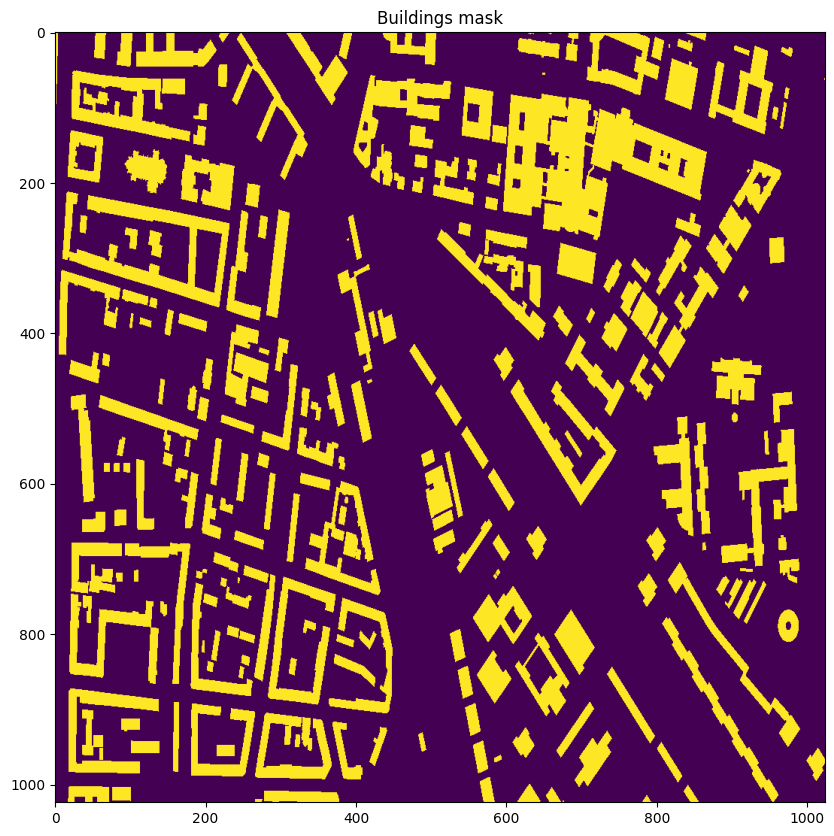

In [15]:
# Create raster
mask = geometry_mask(buildings_gdf.geometry, transform=transform, invert=True, out_shape=(1024, 1024))

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
show(mask, ax=ax)
ax.set_title("Buildings mask")
plt.show()

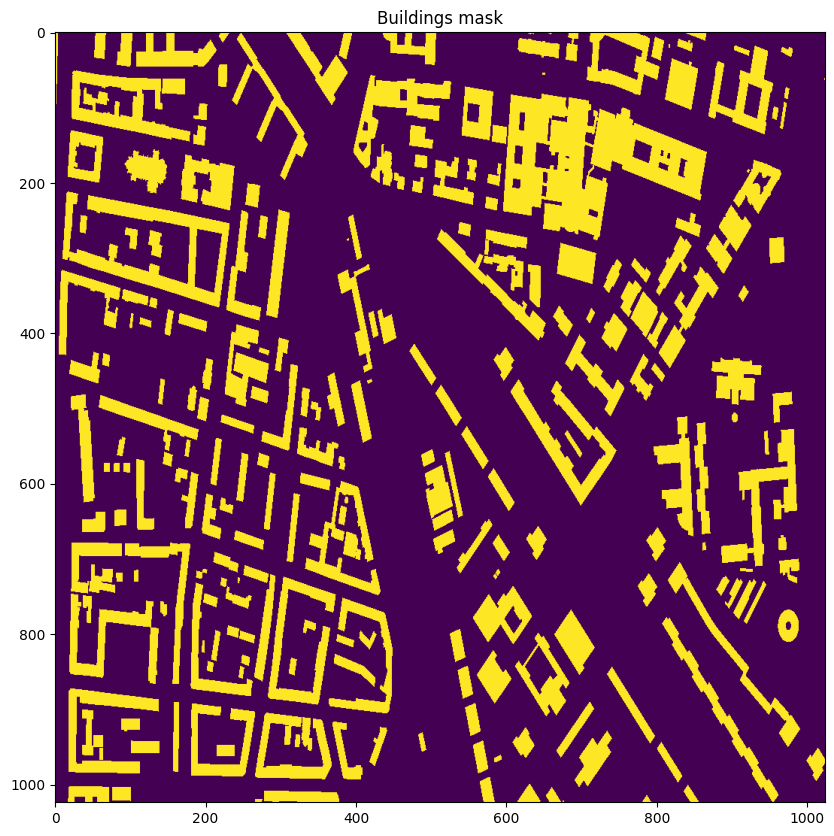

In [16]:
rasterized = rasterize(geom,
    out_shape = (1024, 1024),
    fill = 0,
    out = None,
    transform = transform,
    all_touched = False,
    default_value = 1,
    dtype = None)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
show(rasterized, ax=ax)
ax.set_title("Buildings mask")
plt.show()

### Get highest temperatures for last 5 years from DWD

DWD data: 
- an overview on all german stations is available here: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/KL_Tageswerte_Beschreibung_Stationen.txt
- the historic daily data for each station is available for download here: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/
- for a quick search, this page displays the table interactively: https://www.dwd.de/DE/leistungen/klimadatendeutschland/klimadatendeutschland.html 

In [17]:
stations=[{'name': 'Leipzig-Holzhausen', 'lat': 51.3151, 'lon': 12.4462, 'station_id': '02928'},
 {'name': 'Leipzig-Mockau', 'lat': 51.392, 'lon': 12.3962, 'station_id': '02931'},
 {'name': 'Leipzig/Halle', 'lat': 51.4347, 'lon': 12.2396, 'station_id': '02932'}]

stations_gpd = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy([station['lon'] for station in stations], [station['lat'] for station in stations]), crs="EPSG:4326")
stations_gpd.explore()

In [111]:
lz_holzhausen_kl=pd.read_csv(f"{repo_dir}/data/tageswerte_KL_02928_18631201_20231231_hist/produkt_klima_tag_18631201_20231231_02928.txt", sep=";")

#trim column names
lz_holzhausen_kl.columns = [col.strip() for col in lz_holzhausen_kl.columns]

# date to datetime64
lz_holzhausen_kl['MESS_DATUM'] = pd.to_datetime(lz_holzhausen_kl['MESS_DATUM'], format="%Y%m%d")

lz_holzhausen_kl.head()

STATIONS_ID MESS_DATUM  QN_3     FX     FM  QN_4  RSK  RSKF    SDK  \
0         2928 1863-12-01  -999 -999.0 -999.0     1  0.1     1 -999.0   
1         2928 1863-12-02  -999 -999.0 -999.0     1  0.1     1 -999.0   
2         2928 1863-12-03  -999 -999.0 -999.0     1  6.0     1 -999.0   
3         2928 1863-12-04  -999 -999.0 -999.0     1  4.7     1 -999.0   
4         2928 1863-12-05  -999 -999.0 -999.0     1  7.6     1 -999.0   

   SHK_TAG   NM  VPM      PM  TMK   UPM  TXK  TNK    TGK  eor  
0        0  0.0  4.7  1009.0 -2.1  90.0  1.8 -4.8 -999.0  eor  
1        0  1.7  5.5   994.1 -0.8  95.0  2.9 -4.3 -999.0  eor  
2        0  6.0  7.3   985.5  4.2  89.0  5.1 -0.9 -999.0  eor  
3        0  8.0  6.4  1000.0  4.0  80.0  5.3  3.3 -999.0  eor  
4        0  7.7  7.2  1013.1  3.9  91.0  4.3  3.4 -999.0  eor

In [112]:
lz_holzhausen_kl.columns

Index(['STATIONS_ID', 'MESS_DATUM', 'QN_3', 'FX', 'FM', 'QN_4', 'RSK', 'RSKF',
       'SDK', 'SHK_TAG', 'NM', 'VPM', 'PM', 'TMK', 'UPM', 'TXK', 'TNK', 'TGK',
       'eor'],
      dtype='object')

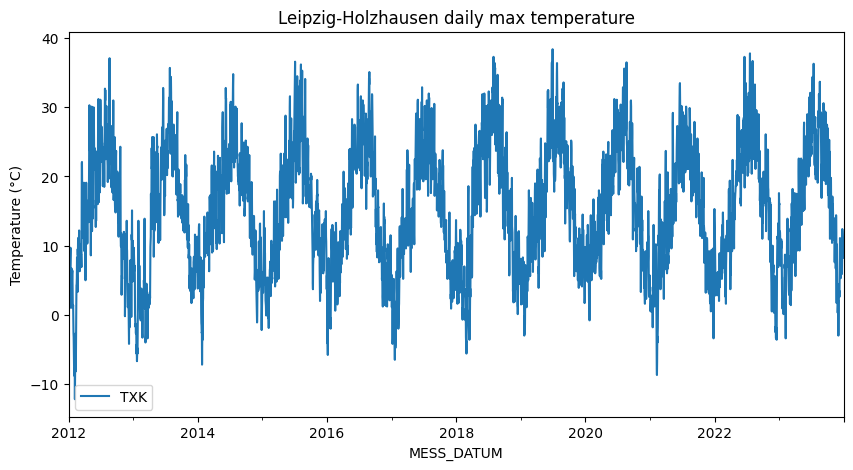

In [113]:
lz_temp_max= lz_holzhausen_kl[['MESS_DATUM','TXK']]

#np.nan for -999 in TXK
lz_temp_max['TXK'] = lz_temp_max['TXK'].replace(-999.0, np.nan)

# rolling mean
last_10_all = lz_temp_max.set_index('MESS_DATUM').loc['2012-01-01':'2023-12-31']

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
last_10_all.plot(ax=ax)
ax.set_title("Leipzig-Holzhausen daily max temperature")
ax.set_ylabel("Temperature (°C)")
plt.show()

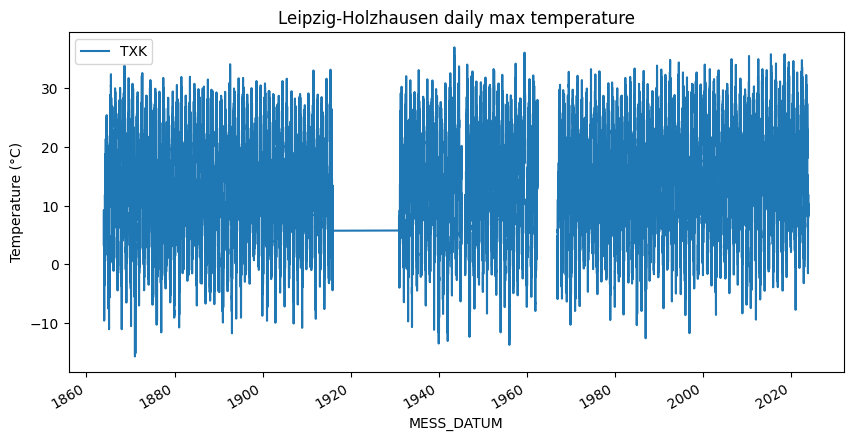

In [114]:
lz_temp_max= lz_holzhausen_kl[['MESS_DATUM','TXK']]

#np.nan for -999 in TXK
lz_temp_max['TXK'] = lz_temp_max['TXK'].replace(-999.0, np.nan)

# rolling mean
lz_temp_max_rolling = lz_temp_max.set_index('MESS_DATUM').rolling(window=3).mean()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
lz_temp_max_rolling.plot(ax=ax)
ax.set_title("Leipzig-Holzhausen daily max temperature")
ax.set_ylabel("Temperature (°C)")
plt.show()

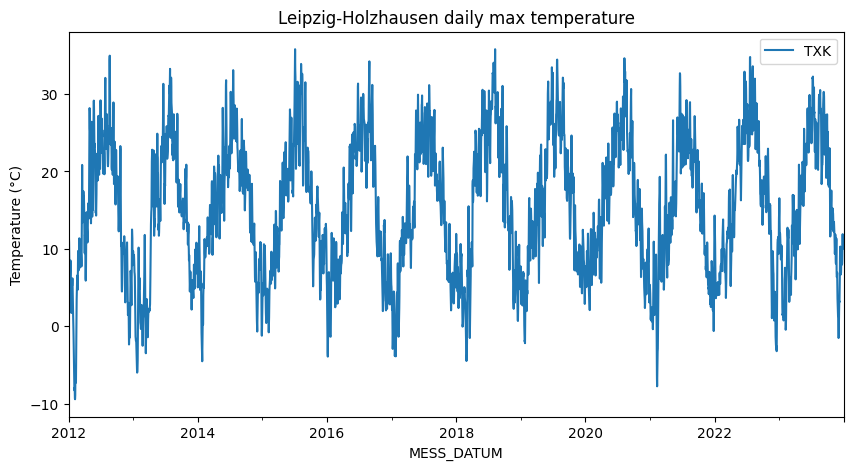

In [115]:
# get last 10 years
last_10=lz_temp_max_rolling.loc['2012-01-01':'2023-12-31']

# plot
fig, ax = plt.subplots(figsize=(10, 5))
last_10.plot(ax=ax)
ax.set_title("Leipzig-Holzhausen daily max temperature")
ax.set_ylabel("Temperature (°C)")
plt.show()

In [91]:
lz_temp_max.groupby(lz_temp_max['TXK'].gt(30).cumsum()).get_group(4).tail(3)

MESS_DATUM   TXK
596 1865-07-19  30.8

In [116]:
lz_temp_max['gt30_roll']=lz_temp_max['TXK'].gt(30).rolling(window=3).sum()

# 3 days in a row temp > 30
lz_temp_max_gt30=lz_temp_max[lz_temp_max['gt30_roll']==3]
lz_temp_max_gt30

MESS_DATUM   TXK  gt30_roll
598   1865-07-21  34.0        3.0
1722  1868-08-18  32.4        3.0
3162  1872-07-28  32.2        3.0
3163  1872-07-29  30.4        3.0
3202  1872-09-06  33.4        3.0
...          ...   ...        ...
52065 2021-06-19  33.5        3.0
52066 2021-06-20  31.0        3.0
52461 2022-07-20  37.8        3.0
52462 2022-07-21  30.3        3.0
52477 2022-08-05  30.8        3.0

[190 rows x 3 columns]

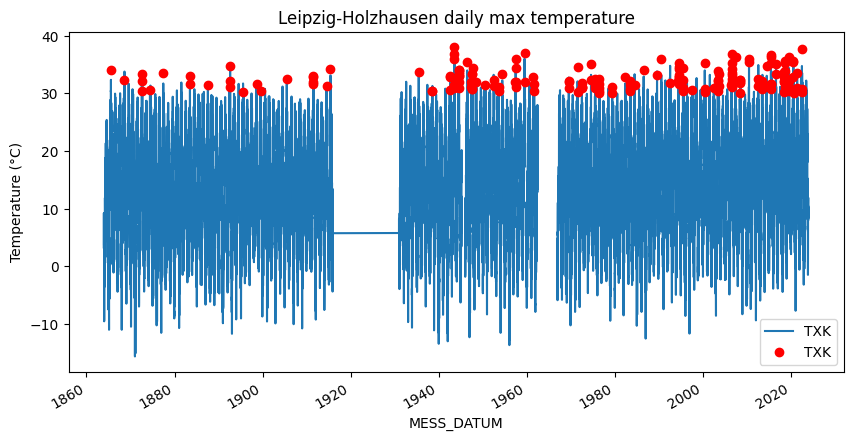

In [117]:
# plot points on rolling mean
fig, ax = plt.subplots(figsize=(10, 5))
lz_temp_max_rolling.plot(ax=ax)
lz_temp_max_gt30.plot(x='MESS_DATUM', y='TXK', style='ro', ax=ax)
ax.set_title("Leipzig-Holzhausen daily max temperature")
ax.set_ylabel("Temperature (°C)")
plt.show()

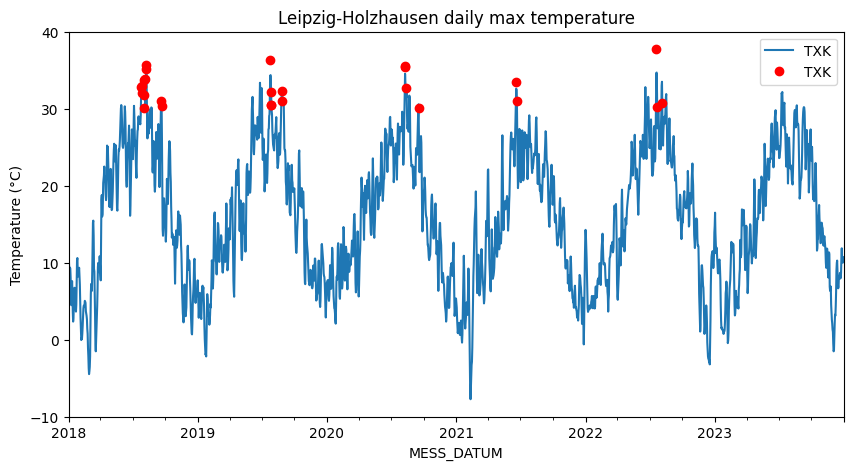

In [118]:
# last 10 years
lz_temp_max_gt30_r10=lz_temp_max_gt30[lz_temp_max_gt30['MESS_DATUM'].dt.year>=2018]
# plot points on rolling mean
fig, ax = plt.subplots(figsize=(10, 5))
lz_temp_max_rolling.loc['2018-01-01':'2023-12-31'].plot(ax=ax)
lz_temp_max_gt30_r10.plot(x='MESS_DATUM', y='TXK', style='ro', ax=ax)
ax.set_title("Leipzig-Holzhausen daily max temperature")
ax.set_ylabel("Temperature (°C)")
plt.show()

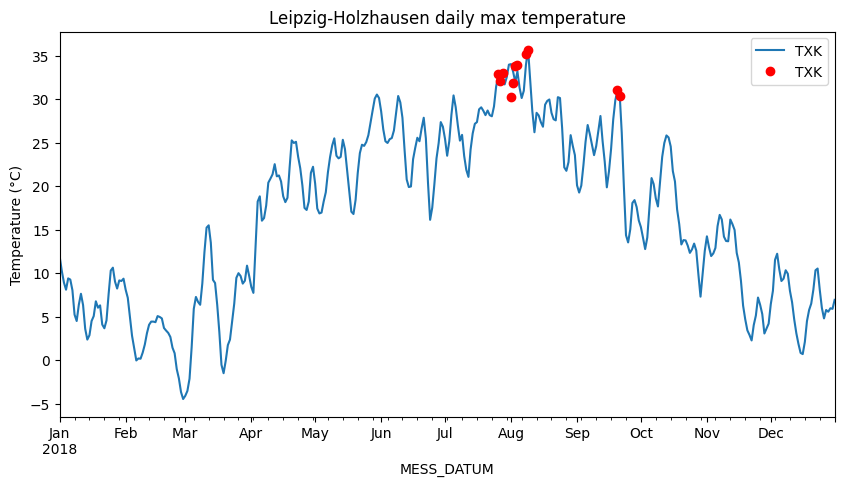

In [119]:
# rolling 3 day sum
lz_temp_max['gt30_roll']=lz_temp_max['TXK'].gt(30).rolling(window=3).sum()

# 3 days in a row temp > 30
lz_temp_max_gt30_3day=lz_temp_max[lz_temp_max['gt30_roll']==3]

def plotTemperatureYearGt30(selected_year):
    global lz_temp_max_rolling, lz_temp_max_gt30
    
    fig, ax = plt.subplots(figsize=(10, 5))
    lz_temp_max_rolling.loc[f'{selected_year}-01-01':f'{selected_year}-12-31'].plot(ax=ax)
    
    gt30_3day_points=lz_temp_max_gt30[lz_temp_max_gt30['MESS_DATUM'].dt.year==selected_year]
    if not gt30_3day_points.empty:
        gt30_3day_points.plot(x='MESS_DATUM', y='TXK', style='ro', ax=ax)
    ax.set_title("Leipzig-Holzhausen daily max temperature")
    ax.set_ylabel("Temperature (°C)")
    plt.show()
    
plotTemperatureYearGt30(2018)

In [120]:
lz_temp_max_gt30[lz_temp_max_gt30['MESS_DATUM'].dt.year==2018]

MESS_DATUM   TXK  gt30_roll
51006 2018-07-26  32.9        3.0
51007 2018-07-27  32.1        3.0
51008 2018-07-28  33.0        3.0
51012 2018-08-01  30.2        3.0
51013 2018-08-02  31.9        3.0
51014 2018-08-03  33.8        3.0
51015 2018-08-04  33.9        3.0
51019 2018-08-08  35.2        3.0
51020 2018-08-09  35.7        3.0
51062 2018-09-20  31.1        3.0
51063 2018-09-21  30.4        3.0

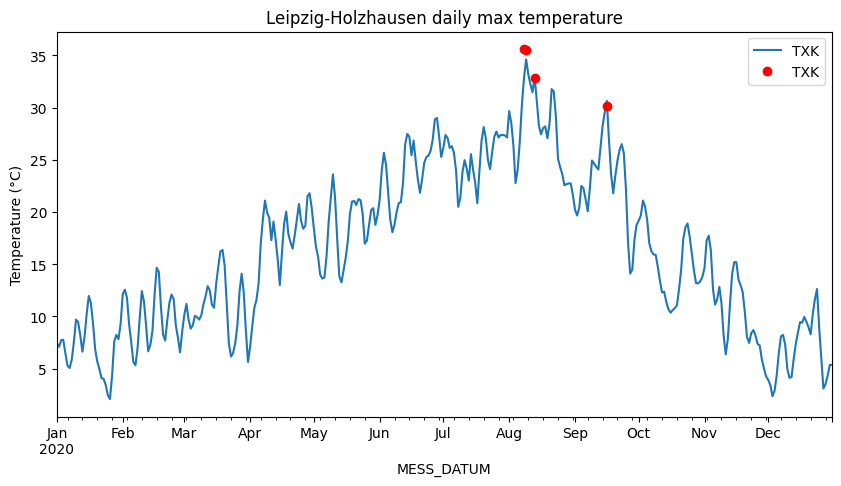

In [130]:
plotTemperatureYearGt30(2020)

### Get LST Data from Sentinel-3

collection script: https://code.usgs.gov/eros-user-services/quick-guides/querying-the-stac-api-with-geojson-objects/-/blob/main/querying_with_geojson_objects_v3.ipynb?ref_type=heads


From the node api the query options are clear:
https://github.com/stac-utils/stac-server

```bash	
curl -X "POST" "${HOST}/search" \
     -H 'Content-Type: application/json; charset=utf-8' \
     -d $'{
  "collections": [
    "sentinel-2-l2a",
    "sentinel-2-l1c"
  ],
  "bbox": [
    10,
    10,
    15,
    15
  ],
  "query": {
    "eo:cloud_cover": {
      "gte": 0,
      "lte": 5
    }
  },
  "filter": {
    "op": "<",
    "args": [
      "property": "view:sun_elevation"
    ],
    50
  }
  "sortby": {
    "field": "properties.datetime",
    "direction": "desc"
  }
}'
```

In [132]:
def fetch_stac_server(query):
    '''
    Queries the stac-server (STAC) backend.
    query is a python dictionary to pass as json to the request.
    '''
    
    search_url = f"https://landsatlook.usgs.gov/stac-server/search"
    query_return = requests.post(search_url, json=query).json()
    error = query_return.get("message", "")
    if error:
        raise Exception(f"STAC-Server failed and returned: {error}")
        
    if 'code' in query_return: # if query fails, return failure code
        print(query_return)   
    else:
        features = query_return['features']
        print(f"{len(features)} STAC items found")
        if len(features) > 0:
            print(f"first feature: {features[0]}")
            
            query_gdf = gpd.GeoDataFrame.from_features(features, crs="EPSG:4326")
            query_gdf['assets'] = [ 
                feature["assets"]
                for feature in features
            ]
            query_gdf['description'] = [feature["description"] for feature in features]
            query_gdf['stac_id']= [feature["id"] for feature in features]

            return query_gdf
        else:
            print("No features found")
            return None

In [133]:
def send_STAC_query(limit=200, collections='landsat-c2l2-sr', intersects=None, year:str=None, month:str=None, date_list:list[str]=None):
    '''
    This function helps to create a simple parameter dictionary for querying 
    the Landsat Collection 2 Level 2 Surface Reflectance feature in the STAC Server.
    It prints the parameter dictionary and returns the query results.
    
    args:
    limit: int, default 200, number of items to return
    collections: str, default 'landsat-c2l2-sr', collection to query
    intersects: dict, default None, geometry to intersect with
    year: str, default None, year to filter by
    month: str, default None, month to filter by in format '01'
    date_list: list, default None, list of dates (YYYY-MM-DD) to filter by
    '''
    params = {}
    if limit is not None:
        params['limit'] = limit
    
    if collections is not None:
        params['collections'] = collections
        
    if intersects is not None:
        params['intersects'] = intersects
        
    #filter by date
    if date_list is not None:
        formatted_dates = [f"{date}T00:00:00Z" for date in date_list]
        params["datetime"] = ",".join(formatted_dates)

        all_results = []

        for date in date_list:
            params["datetime"] = f"{date}T00:00:00Z/{date}T23:59:59Z"
            
            print(f"Querying STAC for date: {date}")
            result = fetch_stac_server(params)

            if result is not None:
                all_results.append(result)

        if all_results:
            return gpd.pd.concat(all_results, ignore_index=True)
        else:
            return None
        
    else:
        max_day = 31
        if month is not None:
            #set max day for month
            if month in ['04', '06', '09', '11']:
                max_day = 30
            elif month == '02':
                max_day = 28
        
        if year is not None or month is not None:        
            params['datetime'] = f"{year if year else '1970'}-{month if month else '01'}-01T00:00:00Z/{year if year else '2025'}-{month if month else '12'}-{max_day}T23:59:59Z"
        
        print(params) 
        
        return fetch_stac_server(params)

In [134]:
bbox_polygon=json.loads(bbox_gdf.to_json())['features'][0]['geometry']
query_gdf = send_STAC_query(intersects=bbox_polygon, limit=20, year='2020') #,month='06') #,date_list=['2020-01-01', '2022-10-14'])
query_gdf.head(2)

{'limit': 20, 'collections': 'landsat-c2l2-sr', 'intersects': {'type': 'Polygon', 'coordinates': [[[12.5019, 51.2705], [12.5019, 51.4174], [12.2714, 51.4174], [12.2714, 51.2705], [12.5019, 51.2705]]]}, 'datetime': '2020-01-01T00:00:00Z/2020-12-31T23:59:59Z'}
20 STAC items found
first feature: {'type': 'Feature', 'stac_version': '1.0.0', 'stac_extensions': ['https://landsat.usgs.gov/stac/landsat-extension/v1.1.1/schema.json', 'https://stac-extensions.github.io/view/v1.0.0/schema.json', 'https://stac-extensions.github.io/projection/v1.0.0/schema.json', 'https://stac-extensions.github.io/file/v1.0.0/schema.json', 'https://stac-extensions.github.io/eo/v1.0.0/schema.json', 'https://stac-extensions.github.io/alternate-assets/v1.1.0/schema.json', 'https://stac-extensions.github.io/storage/v1.0.0/schema.json', 'https://stac-extensions.github.io/classification/v1.0.0/schema.json'], 'id': 'LC08_L2SP_194024_20201210_20210313_02_T2_SR', 'description': 'Landsat Collection 2 Level-2 Surface Reflecta

geometry  \
0  POLYGON ((10.31655 52.76067, 9.60206 51.06198,...   
1  POLYGON ((11.8633 52.76048, 11.14873 51.06183,...   

                      datetime  eo:cloud_cover  view:sun_azimuth  \
0  2020-12-10T10:09:29.230396Z          100.00        166.155470   
1  2020-12-03T10:03:18.404907Z           97.95        166.739881   

   view:sun_elevation   platform  instruments  view:off_nadir  \
0           14.248329  LANDSAT_8  [OLI, TIRS]               0   
1           15.127626  LANDSAT_8  [OLI, TIRS]               0   

   landsat:cloud_cover_land landsat:wrs_type  ... accuracy:geometric_x_bias  \
0                    100.00                2  ...                       NaN   
1                     97.95                2  ...                       NaN   

  accuracy:geometric_y_bias accuracy:geometric_x_stddev  \
0                       NaN                         NaN   
1                       NaN                         NaN   

  accuracy:geometric_y_stddev accuracy:geometric_rmse card4l:specification  \
0                         NaN                     NaN                  NaN   
1                         NaN                     NaN                  NaN   

   card4l:specification_version  \
0                           NaN   
1                           NaN   

                                              assets  \
0  {'thumbnail': {'title': 'Thumbnail image', 'ty...   
1  {'thumbnail': {'title': 'Thumbnail image', 'ty...   

                                         description  \
0  Landsat Collection 2 Level-2 Surface Reflectan...   
1  Landsat Collection 2 Level-2 Surface Reflectan...   

                                       stac_id  
0  LC08_L2SP_194024_20201210_20210313_02_T2_SR  
1  LC08_L2SP_193024_20201203_20210313_02_T2_SR  

[2 rows x 31 columns]

In [135]:
#query_gdf.boundary.explore()
query_gdf.explore(fill=0)

In [238]:
query_gdf.datetime

0     2020-12-10T10:09:29.230396Z
1     2020-12-03T10:03:18.404907Z
2     2020-11-24T10:09:27.884427Z
3     2020-11-17T10:03:15.110009Z
4     2020-11-16T09:30:56.492299Z
5     2020-11-09T09:25:14.845222Z
6     2020-11-01T10:03:16.245971Z
7     2020-10-31T09:32:02.417994Z
8     2020-10-24T09:26:19.614703Z
9     2020-10-23T10:09:28.114913Z
10    2020-10-16T10:03:17.458782Z
11    2020-10-15T09:33:05.795023Z
12    2020-10-08T09:27:22.050560Z
13    2020-10-07T10:09:27.705314Z
14    2020-09-30T10:03:15.876202Z
15    2020-09-29T09:34:07.126587Z
16    2020-09-22T09:28:22.627792Z
17    2020-09-21T10:09:24.616081Z
18    2020-09-14T10:03:11.661077Z
19    2020-09-13T09:35:09.597950Z
Name: datetime, dtype: object

query the 30 degree temperature data

In [125]:
gt30_3day_5years=lz_temp_max_gt30_3day[lz_temp_max_gt30_3day.MESS_DATUM.dt.year>=2018]
gt30_3day_5years_dates=gt30_3day_5years.MESS_DATUM.to_list()

# get dates in format YYYY-MM-DD
gt30_3day_5years_dates=[date.strftime("%Y-%m-%d") for date in gt30_3day_5years_dates]
#gt30_3day_5years_dates

In [136]:
query_gdf = send_STAC_query(intersects=bbox_polygon, limit=1, date_list=gt30_3day_5years_dates, collections='landsat-c2l2-st')
query_gdf.head(2)

Querying STAC for date: 2018-07-26
0 STAC items found
No features found
Querying STAC for date: 2018-07-27
0 STAC items found
No features found
Querying STAC for date: 2018-07-28
0 STAC items found
No features found
Querying STAC for date: 2018-08-01
0 STAC items found
No features found
Querying STAC for date: 2018-08-02
0 STAC items found
No features found
Querying STAC for date: 2018-08-03
0 STAC items found
No features found
Querying STAC for date: 2018-08-04
0 STAC items found
No features found
Querying STAC for date: 2018-08-08
1 STAC items found
first feature: {'type': 'Feature', 'stac_version': '1.0.0', 'stac_extensions': ['https://landsat.usgs.gov/stac/landsat-extension/v1.1.1/schema.json', 'https://stac-extensions.github.io/view/v1.0.0/schema.json', 'https://stac-extensions.github.io/projection/v1.0.0/schema.json', 'https://stac-extensions.github.io/eo/v1.0.0/schema.json', 'https://stac-extensions.github.io/alternate-assets/v1.1.0/schema.json', 'https://stac-extensions.github.

geometry  \
0  POLYGON ((11.89839 52.76113, 11.1825 51.06267,...   
1  POLYGON ((10.11083 52.69589, 9.45272 51.11283,...   

                      datetime  eo:cloud_cover  view:sun_azimuth  \
0  2018-08-08T10:02:19.405298Z           30.12        151.463725   
1  2019-07-25T09:57:12.163744Z            0.00        144.699118   

   view:sun_elevation   platform  instruments  view:off_nadir  \
0           51.627690  LANDSAT_8  [OLI, TIRS]               0   
1           53.930067  LANDSAT_7        [ETM]               0   

   landsat:cloud_cover_land landsat:wrs_type  ... proj:epsg    proj:shape  \
0                     30.12                2  ...     32633  [8151, 8061]   
1                      0.00                2  ...     32632  [7311, 8241]   

                     proj:transform card4l:specification  \
0  [30, 0, 230685, 0, -30, 5850915]                   ST   
1  [30, 0, 524985, 0, -30, 5840715]                   ST   

  card4l:specification_version                   created  \
0                          5.0  2022-06-29T05:02:13.925Z   
1                          5.0  2022-06-28T15:58:02.540Z   

                    updated  \
0  2022-07-07T10:32:19.688Z   
1  2022-06-28T15:58:02.540Z   

                                              assets  \
0  {'thumbnail': {'title': 'Thumbnail image', 'ty...   
1  {'thumbnail': {'title': 'Thumbnail image', 'ty...   

                                         description  \
0  Landsat Collection 2 Level-2 Surface Temperatu...   
1  Landsat Collection 2 Level-2 Surface Temperatu...   

                                       stac_id  
0  LC08_L2SP_193024_20180808_20200831_02_T1_ST  
1  LE07_L2SP_194024_20190725_20200825_02_T1_ST  

[2 rows x 31 columns]

save as geoparquet

In [137]:
query_gdf.to_parquet(f"{repo_dir}/data/landsat_query_gt30_2018_2022.parquet")

In [2]:
query_gdf=gpd.read_parquet(f"{repo_dir}/data/landsat_query_gt30_2018_2022.parquet")
query_gdf.explore()

Get the images for the requested collection information

For information on the asset links:
https://landsat.usgs.gov/stac/LC09_L2SP_095022_20220625_20220627_02_T1_ST_stac.json

```python
assets=requests.get('https://landsat.usgs.gov/stac/LC09_L2SP_095022_20220625_20220627_02_T1_ST_stac.json').json()['assets']
assets
```

We also stored them in the geodataframe:

In [77]:
query_gdf.iloc[0].assets

{'ANG.txt': {'alternate': {'s3': {'href': 's3://usgs-landsat/collection02/level-2/standard/oli-tirs/2018/193/024/LC08_L2SP_193024_20180808_20200831_02_T1/LC08_L2SP_193024_20180808_20200831_02_T1_ANG.txt',
    'storage:platform': 'AWS',
    'storage:requester_pays': True}},
  'description': 'Collection 2 Level-2 Angle Coefficients File (ANG)',
  'file:checksum': '134073be283c780d9f779dc2bda8c7dbf612dec14c0b52dd00b7fa710cb8b515636ceb278e90e48835435391dd7ad89be11a03d094ac2415c754d594190920ae61cd',
  'href': 'https://landsatlook.usgs.gov/data/collection02/level-2/standard/oli-tirs/2018/193/024/LC08_L2SP_193024_20180808_20200831_02_T1/LC08_L2SP_193024_20180808_20200831_02_T1_ANG.txt',
  'roles': array(['metadata'], dtype=object),
  'title': 'Angle Coefficients File',
  'type': 'text/plain'},
 'ATRAN': {'alternate': {'s3': {'href': 's3://usgs-landsat/collection02/level-2/standard/oli-tirs/2018/193/024/LC08_L2SP_193024_20180808_20200831_02_T1/LC08_L2SP_193024_20180808_20200831_02_T1_ST_ATRAN.

To pre-process the LST data correctly, the QA bands from Landsat should be considered as well:

| QA Band | What it contains | Primary purpose |
|---------|------------------|-----------------|
| qa (ST_QA) | Basic surface temperature QA | Indicates confidence in the ST retrieval (based on conditions like cloud cover, emissivity, etc.) |
| qa_pixel (QA_PIXEL) | Full pixel quality assessment | Provides cloud, snow, water, and cirrus flags — very useful for masking out unreliable pixels. |
| qa_radsat (QA_RADSAT) | Radiometric saturation QA | Tells if specific spectral bands are saturated — typically important for reflectance bands, less so for LST. |

In [8]:
def requestLandsatTemperatureProducts(query_gdf):
    '''
    This function retrieves the Landsat 8 Surface Temperature products from the USGS server.
    It returns a list of the product urls.
    '''
    products = []
    for index, row in query_gdf.iterrows():
        assets = row.assets
        if 'lwir11' in assets and assets['lwir11'] is not None:
            products.append({"stac_id": row.stac_id, "datetime": row.datetime,
                             "thermal": {
                             "url": assets['lwir11']['href'],
                             "alternate": assets['lwir11']['alternate']},
                            "qa_pixel":{"url": assets['qa_pixel']['href'], "alternate": assets['qa_pixel']['alternate']}
                            })
                            
        elif 'lwir' in assets and assets['lwir'] is not None:
            print(f"found only B6 from Landsat 7 for {row.stac_id}")
            # products.append({"stac_id": row.stac_id, "datetime": row.datetime, 
                            #  "url": assets['lwir']['href'], "alternate": assets['lwir']['alternate']})
            
        else:
            print(f"No lwir11 asset for {row.stac_id}")

    return products

products=requestLandsatTemperatureProducts(query_gdf)
products[0]

found only B6 from Landsat 7 for LE07_L2SP_194024_20190725_20200825_02_T1_ST
found only B6 from Landsat 7 for LE07_L2SP_193024_20220720_20220903_02_T1_ST


{'stac_id': 'LC08_L2SP_193024_20180808_20200831_02_T1_ST',
 'datetime': '2018-08-08T10:02:19.405298Z',
 'thermal': {'url': 'https://landsatlook.usgs.gov/data/collection02/level-2/standard/oli-tirs/2018/193/024/LC08_L2SP_193024_20180808_20200831_02_T1/LC08_L2SP_193024_20180808_20200831_02_T1_ST_B10.TIF',
  'alternate': {'s3': {'href': 's3://usgs-landsat/collection02/level-2/standard/oli-tirs/2018/193/024/LC08_L2SP_193024_20180808_20200831_02_T1/LC08_L2SP_193024_20180808_20200831_02_T1_ST_B10.TIF',
    'storage:platform': 'AWS',
    'storage:requester_pays': True}}},
 'qa_pixel': {'url': 'https://landsatlook.usgs.gov/data/collection02/level-2/standard/oli-tirs/2018/193/024/LC08_L2SP_193024_20180808_20200831_02_T1/LC08_L2SP_193024_20180808_20200831_02_T1_QA_PIXEL.TIF',
  'alternate': {'s3': {'href': 's3://usgs-landsat/collection02/level-2/standard/oli-tirs/2018/193/024/LC08_L2SP_193024_20180808_20200831_02_T1/LC08_L2SP_193024_20180808_20200831_02_T1_QA_PIXEL.TIF',
    'storage:platform': 

In [9]:
aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")

# Setup boto3 client
s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name='us-west-2'
)

def parse_s3_url(s3_url):
    if s3_url.startswith("s3://"):
        s3_url = s3_url[5:]
    bucket, key = s3_url.split("/", 1)
    return bucket, key

class TqdmFileWrapper:
    def __init__(self, fileobj, tqdm_bar):
        self.fileobj = fileobj
        self.tqdm_bar = tqdm_bar

    def write(self, data):
        self.fileobj.write(data)
        self.tqdm_bar.update(len(data))

    def close(self):
        self.fileobj.close()

def download_tif(s3_url, local_path):
    bucket, key = parse_s3_url(s3_url)

    # First, find out the file size
    head = s3.head_object(Bucket=bucket, Key=key, RequestPayer='requester')
    file_size = head['ContentLength']

    # Setup tqdm progress bar
    with tqdm(total=file_size, unit='B', unit_scale=True, desc=f"Downloading {os.path.basename(local_path)}") as pbar:
        with open(local_path, 'wb') as f:
            wrapped_file = TqdmFileWrapper(f, pbar)
            s3.download_fileobj(
                Bucket=bucket,
                Key=key,
                Fileobj=wrapped_file,
                ExtraArgs={'RequestPayer': 'requester'}
            )


def requestProduct(product):
    '''
    This function retrieves the product from the USGS server and saves it to the output path.
    '''
    
    output_path_base = f"{repo_dir}/data/landsat_temperature/{product['stac_id']}"
    output_path_thermal = f"{output_path_base}_thermal.tif"
    output_path_qa_pixel = f"{output_path_base}_qa_pixel.tif"
    
    if not os.path.exists(output_path_thermal):
        os.makedirs(os.path.dirname(output_path_thermal), exist_ok=True)
        s3_url = product["thermal"]['alternate']['s3']['href']
        download_tif(s3_url, output_path_thermal)

    if not os.path.exists(output_path_qa_pixel):
        os.makedirs(os.path.dirname(output_path_qa_pixel), exist_ok=True)
        s3_url = product["qa_pixel"]['alternate']['s3']['href']
        download_tif(s3_url, output_path_qa_pixel)

    return

requestProduct(products[1])

Thread download all the datasets

In [ ]:
def process_all_products(products, max_workers=8):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        {executor.submit(requestProduct, product): product for product in products}

process_all_products(products)

Open the first file to plot and clip to bbox

In [15]:
files=os.listdir(f"{repo_dir}/data/landsat_temperature")
files=[file for file in files if file.startswith("LC08")]
files=[f"{repo_dir}/data/landsat_temperature/{file}" for file in files]

thermal_files=[file for file in files if file.endswith("thermal.tif")]
qa_pixel_files=[file for file in files if file.endswith("qa_pixel.tif")]

xds = rxr.open_rasterio(thermal_files[0])

#clip to bbox
xds = xds.rio.clip([bbox_gdf.geometry.iloc[0]], bbox_gdf.crs)

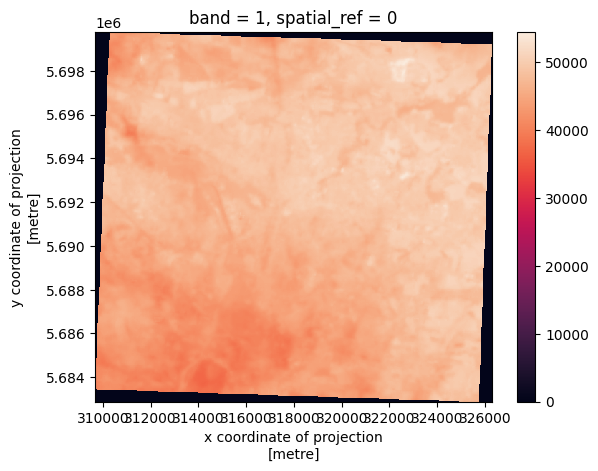

In [16]:
#seaborn cmap
rocket=sns.color_palette("rocket", as_cmap=True)
mako=sns.color_palette("mako", as_cmap=True)

xds.plot(cmap=rocket)

Assessing the quality band

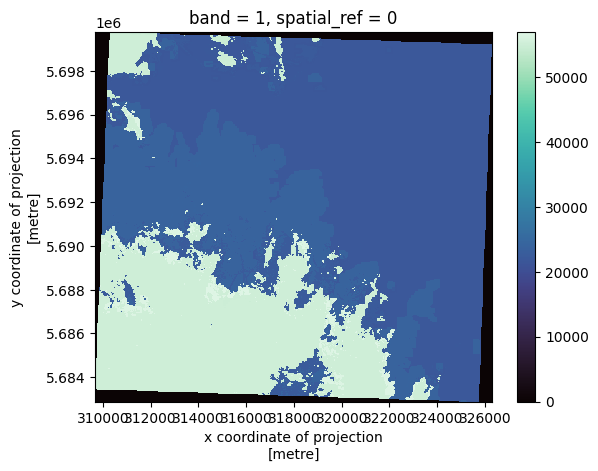

In [42]:
xds_qa = rxr.open_rasterio(qa_pixel_files[0])
xds_qa = xds_qa.rio.clip([bbox_gdf.geometry.iloc[0]], bbox_gdf.crs)
xds_qa.plot(cmap=mako)

In [43]:
# Define bit positions for cloud and cloud shadow
CLOUD_SHADOW_BIT = 3  # Bit 3 = cloud shadow
CLOUD_BIT = 5         # Bit 5 = cloud

# Create masks
cloud_shadow_mask = (xds_qa & (1 << CLOUD_SHADOW_BIT)) == 0  # True = no shadow
cloud_mask = (xds_qa & (1 << CLOUD_BIT)) == 0                 # True = no cloud

clear_mask = cloud_shadow_mask & cloud_mask
xds_qa = clear_mask.astype(np.uint8)

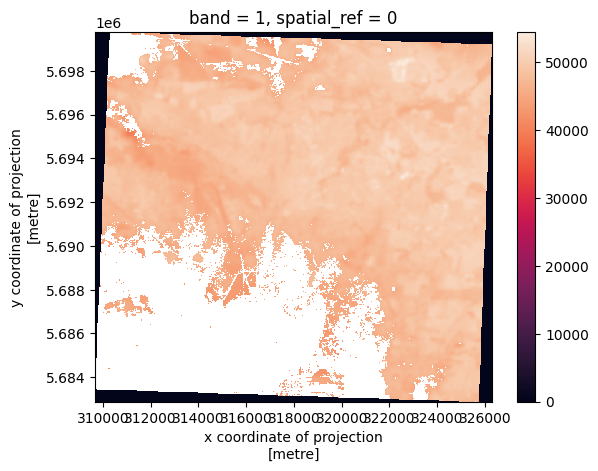

In [44]:
xds.where(xds_qa).plot(cmap=rocket)

To obtain actual temperature values, the Landsat specific scale and offset values need to be applied to the data, like indicated here: https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products

A good tutorial on how to process satellite imagery: https://medium.com/@ridhomuh002/analyzing-land-surface-temperature-lst-with-landsat-8-data-in-google-earth-engine-f4dd7ca28e70

Create a processed zarr for the Landsat data

In [29]:
files=os.listdir(f"{repo_dir}/data/landsat_temperature")
files=[file for file in files if file.startswith("LC08")]
file_paths=[f"{repo_dir}/data/landsat_temperature/{file}" for file in files]
file_set=[file_paths[i:i+2] for i in range(0, len(file_paths), 2)]

In [142]:
#### create landsat zarr ###

#read files
files=os.listdir(f"{repo_dir}/data/landsat_temperature")
files=[file for file in files if file.startswith("LC08")]
file_paths=[f"{repo_dir}/data/landsat_temperature/{file}" for file in files]
file_sets=[file_paths[i:i+2] for i in range(0, len(file_paths), 2)]

# find file in query_gdf
def find_file(stac_id):
    return query_gdf[query_gdf['stac_id']==stac_id].iloc[0]

# read file function with metadata attached
def readLandsatTifsToXarrayDS(ds_file_path_set):
    """
    Read Landsat tif files to xarray dataset and attach metadata.
    
    args:
    file_path: str, path to the tif file    
    """
    
    thermal_file_path=ds_file_path_set[1]
    qa_pixel_file_path=ds_file_path_set[0]
    
    if not os.path.exists(thermal_file_path):
        print(f"File not found: {thermal_file_path}")
        return None
    if not os.path.exists(qa_pixel_file_path):
        print(f"File not found: {qa_pixel_file_path}")
        return None
    
    #####create thermal data array######
    #read file
    xda=rxr.open_rasterio(thermal_file_path, masked=True)
    
    #clip to bbox
    xda = xda.rio.clip([bbox_gdf.geometry.iloc[0]], bbox_gdf.crs)
    
    # apply scaling factor to degrees celsius
    scale_factor=0.00341802
    add_offset=149.0-273.15
    xda=xda*scale_factor+add_offset
    xda.attrs['scale_factor']=scale_factor
    xda.attrs['add_offset']=add_offset
    
    #rename data array
    xda=xda.rename('surface_temp_b10')
    
    
    #####create qa pixel data array#######
    #read file
    xda_qa=rxr.open_rasterio(qa_pixel_file_path)
    
    #clip to bbox
    xda_qa = xda_qa.rio.clip([bbox_gdf.geometry.iloc[0]], bbox_gdf.crs)
    
    #mask cloud and cloud shadow
    # Define bit positions for cloud and cloud shadow
    CLOUD_SHADOW_BIT = 3  # Bit 3 = cloud shadow
    CLOUD_BIT = 5         # Bit 5 = cloud

    # Create masks
    cloud_shadow_mask = (xda_qa & (1 << CLOUD_SHADOW_BIT)) == 0  # True = no shadow
    cloud_mask = (xda_qa & (1 << CLOUD_BIT)) == 0                 # True = no cloud

    clear_mask = cloud_shadow_mask & cloud_mask
    xda_qa = clear_mask.astype(np.uint8)
    
    #rename data array
    xda_qa=xda_qa.rename('qa_pixel')
    
    
    #####create masked array #####
    #create masked array
    xda_mask=xda.where(xda_qa)
    
    #rename data array
    xda_mask=xda_mask.rename('surface_temp_b10_masked')
    
    
    #####combine data arrays####
    xds=xr.merge([xda, xda_qa, xda_mask])
    
    
    #####add metadata#####
    # get stac data
    stac_id=thermal_file_path.split("/")[-1].split(".")[0].split("_thermal")[0]
    file=find_file(stac_id)
    date=file.datetime
    
    #add general metadata
    xds.attrs['title']="Landsat 8 Surface Temperature"
    xds.attrs['description']="Landsat 8 Surface Temperature data from USGS for specific hot days (3 continous >30C° days) in Leipzig"
    xds.attrs['source']="USGS"
    xds.attrs['crs']="EPSG:4326"
    xds.attrs['bbox']=bbox_gdf.to_json()
    xds.attrs['variables']={"surface_temp_b10": "Surface Temperature Band (B10)",
                            "qa_pixel": "Quality Assessment Pixel",
                            "surface_temp_b10_masked": "Surface Temperature Band (B10) Masked"}
    xds.attrs['units']={"surface_temp_b10": "°C", "qa_pixel": "1", "surface_temp_b10_masked": "°C"}
    
    #remove scale_factor and add_offset from attrs
    xds.attrs.pop('scale_factor', None)
    xds.attrs.pop('add_offset', None)
    
    #remove spatial_ref and band coords
    xds=xds.drop_vars(["spatial_ref", "band"])
    
    #squeeze band from variables
    xds=xds.squeeze("band", drop=True)
    
    # add time coordinate
    xds=xds.expand_dims(time=[date])
    # xds=xds.expand_dims(stac_id=[stac_id])
    # xds=xds.expand_dims(view_sun_elevation=[file['view:sun_elevation']])
    # xds=xds.expand_dims(view_sun_azimuth=[file['view:sun_azimuth']])
    # xds=xds.expand_dims(view_off_nadir=[file['view:off_nadir']])

    #add metadata as variables over time
    xds['stac_id']=xr.DataArray([stac_id], dims=['time'])
    xds['view_sun_elevation']=xr.DataArray([file['view:sun_elevation']], dims=['time'])
    xds['view_sun_azimuth']=xr.DataArray([file['view:sun_azimuth']], dims=['time'])
    xds['view_off_nadir']=xr.DataArray([file['view:off_nadir']], dims=['time'])

    return xds

# read all files
xds_list=[readLandsatTifsToXarrayDS(file_set) for file_set in file_sets]
#landsat_xr_ds=readLandsatTifsToXarrayDS(file_sets[0])

Weirdly one of the requested scenes does not show the region specified when running the stac request as seen in the following:

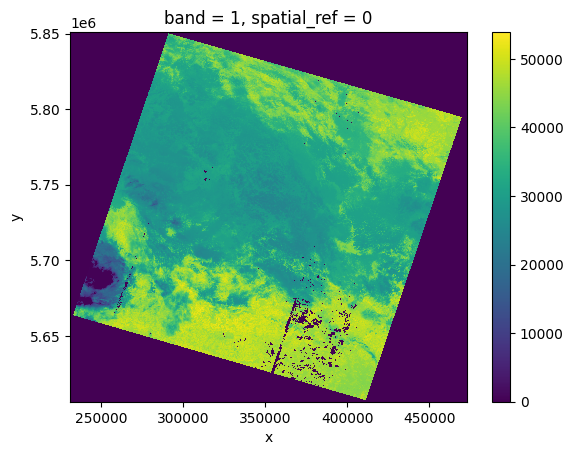

In [212]:
rxr.open_rasterio(thermal_files[3]).plot()#.rio.clip([bbox_gdf.geometry.iloc[0]], bbox_gdf.crs).plot()

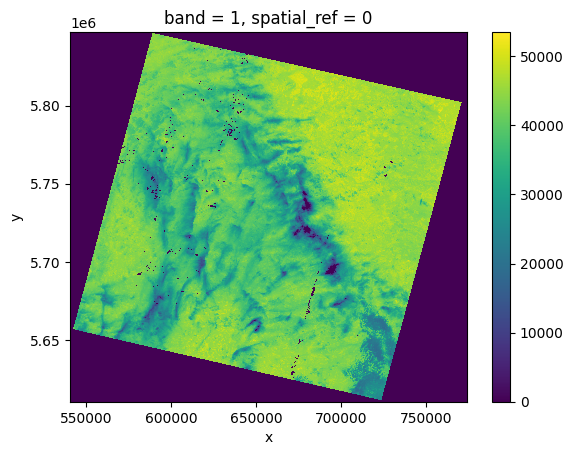

In [211]:
rxr.open_rasterio(thermal_files[4]).plot()#.rio.clip([bbox_gdf.geometry.iloc[0]], bbox_gdf.crs).plot()

Therefore, the coordinates should be be reindexed to a template grid before concatenating the data:

In [215]:
common_x = xds_list[0].x
common_y = xds_list[0].y

xds_list = [
    ds.reindex(x=common_x, y=common_y, method="nearest")  # or method="pad"
    for ds in xds_list
]


In [ ]:
#combine datasets
landsat_xr_ds=xr.concat(xds_list, dim='time')

#save as zarr dataset
landsat_xr_ds.to_zarr(f"{repo_dir}/data/landsat_temperature_gt30_2018_2022.zarr", mode='w')

In [229]:
landsat_xr_ds=xr.open_zarr(f"{repo_dir}/data/landsat_temperature_gt30_2018_2022.zarr")
landsat_xr_ds

<xarray.Dataset> Size: 14MB
Dimensions:                  (time: 5, y: 563, x: 554)
Coordinates:
  * time                     (time) object 40B '2018-08-08T10:02:19.405298Z' ...
  * x                        (x) float64 4kB 3.097e+05 3.097e+05 ... 3.263e+05
  * y                        (y) float64 5kB 5.7e+06 5.7e+06 ... 5.683e+06
Data variables:
    stac_id                  (time) object 40B ...
    qa_pixel                 (time, y, x) uint8 2MB ...
    view_off_nadir           (time) int64 40B ...
    surface_temp_b10         (time, y, x) float32 6MB ...
    surface_temp_b10_masked  (time, y, x) float32 6MB ...
    view_sun_elevation       (time) float64 40B ...
    view_sun_azimuth         (time) float64 40B ...
Attributes:
    title:        Landsat 8 Surface Temperature
    description:  Landsat 8 Surface Temperature data from USGS for specific h...
    source:       USGS
    crs:          EPSG:4326
    bbox:         {"type": "FeatureCollection", "features": [{"id": "0", "typ...
    variables:    {'surface_temp_b10': 'Surface Temperature Band (B10)', 'qa_...
    units:        {'surface_temp_b10': '°C', 'qa_pixel': '1', 'surface_temp_b...

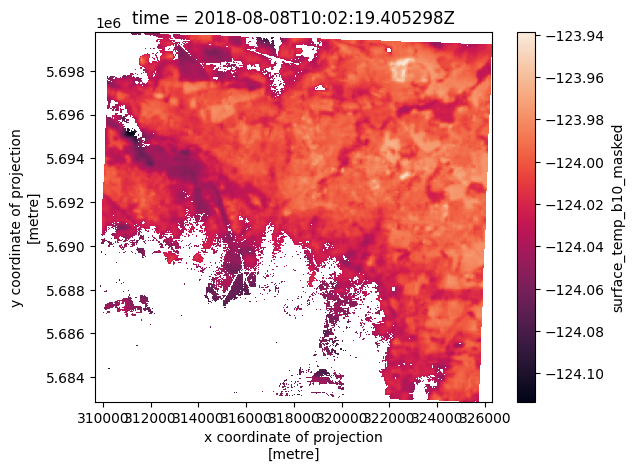

In [230]:
landsat_xr_ds.surface_temp_b10_masked.isel(time=0).plot(cmap=rocket)

### Request Landsat C2 L2 via planetary computer
https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

In [19]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [24]:
landsat = catalog.get_collection("landsat-c2-l2")

pd.DataFrame(landsat.summaries.get_list("eo:bands"))

name common_name                                        description  \
0      TM_B1        blue                     Visible blue (Thematic Mapper)   
1      TM_B2       green                    Visible green (Thematic Mapper)   
2      TM_B3         red                      Visible red (Thematic Mapper)   
3      TM_B4       nir08                    Near infrared (Thematic Mapper)   
4      TM_B5      swir16              Short-wave infrared (Thematic Mapper)   
5      TM_B6        lwir               Long-wave infrared (Thematic Mapper)   
6      TM_B7      swir22              Short-wave infrared (Thematic Mapper)   
7     ETM_B1        blue       Visible blue (Enhanced Thematic Mapper Plus)   
8     ETM_B2       green      Visible green (Enhanced Thematic Mapper Plus)   
9     ETM_B3         red        Visible red (Enhanced Thematic Mapper Plus)   
10    ETM_B4       nir08      Near infrared (Enhanced Thematic Mapper Plus)   
11    ETM_B5      swir16  Short-wave infrared (Enhanced Thematic Mapper ...   
12    ETM_B6        lwir  Long-wave infrared (Enhanced Thematic Mapper P...   
13    ETM_B7      swir22  Short-wave infrared (Enhanced Thematic Mapper ...   
14    OLI_B1     coastal          Coastal/Aerosol (Operational Land Imager)   
15    OLI_B2        blue             Visible blue (Operational Land Imager)   
16    OLI_B3       green            Visible green (Operational Land Imager)   
17    OLI_B4         red              Visible red (Operational Land Imager)   
18    OLI_B5       nir08            Near infrared (Operational Land Imager)   
19    OLI_B6      swir16      Short-wave infrared (Operational Land Imager)   
20    OLI_B7      swir22      Short-wave infrared (Operational Land Imager)   
21  TIRS_B10      lwir11       Long-wave infrared (Thermal Infrared Sensor)   

    center_wavelength  full_width_half_max  
0                0.49                 0.07  
1                0.56                 0.08  
2                0.66                 0.06  
3                0.83                 0.14  
4                1.65                 0.20  
5               11.45                 2.10  
6                2.22                 0.27  
7                0.48                 0.07  
8                0.56                 0.08  
9                0.66                 0.06  
10               0.84                 0.13  
11               1.65                 0.20  
12              11.34                 2.05  
13               2.20                 0.28  
14               0.44                 0.02  
15               0.48                 0.06  
16               0.56                 0.06  
17               0.65                 0.04  
18               0.87                 0.03  
19               1.61                 0.09  
20               2.20                 0.19  
21              10.90                 0.59

In [25]:
pd.DataFrame.from_dict(landsat.extra_fields["item_assets"], orient="index")[
    ["title", "description", "gsd"]
]

title  \
qa             Surface Temperature Quality Assessment Band   
ang                                Angle Coefficients File   
red                                               Red Band   
blue                                             Blue Band   
drad                              Downwelled Radiance Band   
emis                                       Emissivity Band   
emsd                    Emissivity Standard Deviation Band   
lwir                              Surface Temperature Band   
trad                                 Thermal Radiance Band   
urad                                Upwelled Radiance Band   
atran                       Atmospheric Transmittance Band   
cdist                                  Cloud Distance Band   
green                                           Green Band   
nir08                               Near Infrared Band 0.8   
lwir11                            Surface Temperature Band   
swir16                        Short-wave Infrared Band 1.6   
swir22                        Short-wave Infrared Band 2.2   
coastal                               Coastal/Aerosol Band   
mtl.txt                        Product Metadata File (txt)   
mtl.xml                        Product Metadata File (xml)   
cloud_qa                     Cloud Quality Assessment Band   
mtl.json                      Product Metadata File (json)   
qa_pixel                     Pixel Quality Assessment Band   
qa_radsat                                              NaN   
qa_aerosol                 Aerosol Quality Assessment Band   
atmos_opacity                     Atmospheric Opacity Band   

                                                     description    gsd  
qa             Collection 2 Level-2 Quality Assessment Band (...    NaN  
ang                 Collection 2 Level-1 Angle Coefficients File    NaN  
red                                                          NaN    NaN  
blue                                                         NaN    NaN  
drad           Collection 2 Level-2 Downwelled Radiance Band ...    NaN  
emis           Collection 2 Level-2 Emissivity Band (ST_EMIS)...    NaN  
emsd           Collection 2 Level-2 Emissivity Standard Devia...    NaN  
lwir           Collection 2 Level-2 Thermal Infrared Band (ST...    NaN  
trad           Collection 2 Level-2 Thermal Radiance Band (ST...    NaN  
urad           Collection 2 Level-2 Upwelled Radiance Band (S...    NaN  
atran          Collection 2 Level-2 Atmospheric Transmittance...    NaN  
cdist          Collection 2 Level-2 Cloud Distance Band (ST_C...    NaN  
green                                                        NaN    NaN  
nir08                                                        NaN    NaN  
lwir11         Collection 2 Level-2 Thermal Infrared Band (ST...  100.0  
swir16                                                       NaN    NaN  
swir22         Collection 2 Level-2 Short-wave Infrared Band ...    NaN  
coastal        Collection 2 Level-2 Coastal/Aerosol Band (SR_...    NaN  
mtl.txt         Collection 2 Level-2 Product Metadata File (txt)    NaN  
mtl.xml         Collection 2 Level-2 Product Metadata File (xml)    NaN  
cloud_qa       Collection 2 Level-2 Cloud Quality Assessment ...    NaN  
mtl.json       Collection 2 Level-2 Product Metadata File (json)    NaN  
qa_pixel       Collection 2 Level-1 Pixel Quality Assessment ...    NaN  
qa_radsat                                                    NaN    NaN  
qa_aerosol     Collection 2 Level-2 Aerosol Quality Assessmen...    NaN  
atmos_opacity  Collection 2 Level-2 Atmospheric Opacity Band ...    NaN

In [39]:
time_range = "2020-12-01/2020-12-31"
bbox_lz = [xmin, ymin, xmax, ymax]

search = catalog.search(collections=["landsat-c2-l2"], bbox=bbox_lz)
items = search.get_all_items()

planetary_computer_df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
planetary_computer_df.head()

geometry  gsd  \
0  POLYGON ((11.83128 52.75733, 11.11751 51.05878...   30   
1  POLYGON ((11.83064 52.76001, 11.11688 51.06118...   30   
2  POLYGON ((10.27623 52.75774, 9.56285 51.05881,...   30   
3  POLYGON ((11.84418 52.7574, 11.13079 51.05868,...   30   
4  POLYGON ((10.28519 52.76007, 9.57101 51.06119,...   30   

                       created           sci:doi                     datetime  \
0  2025-02-27T09:15:57.698391Z  10.5066/P9OGBGM6  2025-02-24T10:03:04.248729Z   
1  2025-02-27T09:15:56.773108Z  10.5066/P9OGBGM6  2025-02-16T10:02:56.465874Z   
2  2025-02-23T09:13:45.033600Z  10.5066/P9OGBGM6  2025-02-15T10:09:19.482916Z   
3  2025-02-11T09:34:09.959775Z  10.5066/P9OGBGM6  2025-02-08T10:03:05.153703Z   
4  2025-02-19T09:21:48.645376Z  10.5066/P9OGBGM6  2025-02-07T10:09:11.492884Z   

    platform    proj:shape                   description  instruments  \
0  landsat-9  [8141, 8061]  Landsat Collection 2 Level-2  [oli, tirs]   
1  landsat-8  [8151, 8061]  Landsat Collection 2 Level-2  [oli, tirs]   
2  landsat-9  [7871, 7781]  Landsat Collection 2 Level-2  [oli, tirs]   
3  landsat-9  [8141, 8061]  Landsat Collection 2 Level-2  [oli, tirs]   
4  landsat-8  [7881, 7781]  Landsat Collection 2 Level-2  [oli, tirs]   

   eo:cloud_cover  ...       landsat:scene_id  landsat:wrs_path  \
0           46.22  ...  LC91930242025055LGN00               193   
1           49.18  ...  LC81930242025047LGN00               193   
2           94.79  ...  LC91940242025046LGN00               194   
3           11.66  ...  LC91930242025039LGN00               193   
4           95.37  ...  LC81940242025038LGN00               194   

  landsat:wrs_type view:sun_azimuth landsat:correction view:sun_elevation  \
0                2       158.103507               L2SP          26.681177   
1                2       158.587189               L2SP          23.824218   
2                2       158.693523               L2SP          23.492544   
3                2       159.258275               L2SP          21.225046   
4                2       159.317154               L2SP          20.913884   

   landsat:cloud_cover_land landsat:collection_number  \
0                     46.22                        02   
1                     49.18                        02   
2                     94.79                        02   
3                     11.66                        02   
4                     95.37                        02   

   landsat:collection_category   proj:code  
0                           T1  EPSG:32633  
1                           T1  EPSG:32633  
2                           T2  EPSG:32632  
3                           T1  EPSG:32633  
4                           T2  EPSG:32632  

[5 rows x 23 columns]

In [43]:
import pystac
selected_item = items[0]

item = pystac.read_file(selected_item.get_self_href())
signed_item = planetary_computer.sign(item)

response = requests.get(signed_item.assets["lwir11"].href)
response.raise_for_status()

with open(f"{repo_dir}/data/landsat_temperature/ms_planetary_{item.id}.tif", "wb") as f:
    f.write(response.content)

In [56]:
landsat.assets["geoparquet-items"]

<Asset href=abfs://items/landsat-c2-l2.parquet>

In [ ]:
storage_options = landsat.assets["geoparquet-items"].extra_fields["table:storage_options"]

# Read the parquet file
gdf = gpd.read_parquet(
    landsat.assets["geoparquet-items"].href,
    storage_options=storage_options
)

### Get Skysat images from Planet Labs

### Create Cube using Xarray